In [4]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import chi2_contingency
%matplotlib inline

In [5]:
data = pd.read_csv('credit_card_default_analysis.csv')

In [6]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 1. Размер кредитного лимита (LIMIT_BAL).
    Проверка гипотез  для  двух групп людей вернувших (default = 0) и не вернувших кредит (default = 1): a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 

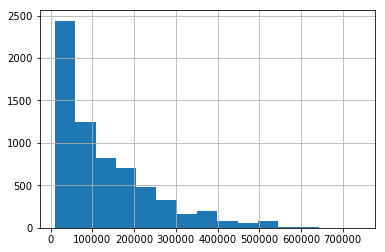

In [7]:
data[data.default == 1]['LIMIT_BAL'].hist(bins=15)

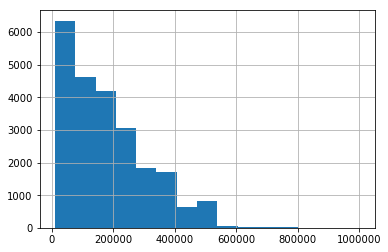

In [8]:
data[data.default == 0]['LIMIT_BAL'].hist(bins=15)

### Точечная оценка разности медиан

In [9]:
data[data.default == 0]['LIMIT_BAL'].median()-data[data.default == 1]['LIMIT_BAL'].median()

60000.0

### Интервальная оценка разности медиан с помощью bootstrap выборок

In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [11]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
Default_data =np.array(data[data.default == 1]['LIMIT_BAL'])
No_default_data = np.array(data[data.default == 0]['LIMIT_BAL'])

In [13]:
Default_median_scores = map(np.median, get_bootstrap_samples(Default_data, 4000))
No_default_median_scores = map(np.median, get_bootstrap_samples(No_default_data, 4000))

In [14]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(Default_median_scores, No_default_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [ 60000.  70000.]


### Перестановочный критерий для двух независимых выборок

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [15]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [16]:
def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [17]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [18]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [19]:
print "p-value: %f" % permutation_test(Default_data, No_default_data, max_permutations = 10000)

p-value: 0.000100


На уровне значимости 0.0001 нулевая гипотеза $H_0$ о равенстве распределений из которых получены группы людей вернувших и невернувших кредит отвергается. 

 ## 2. Пол (SEX)
      Проверка гпотезы: Гендерный состав группы людей вернувших и не вернувших кредит отличается. 

In [20]:
import seaborn 

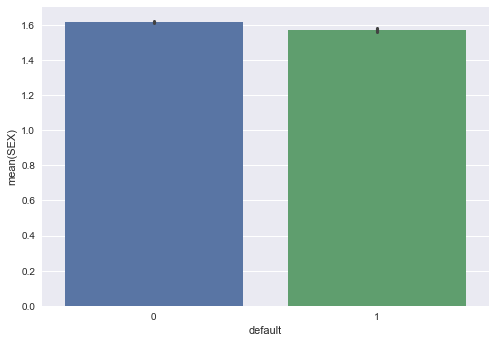

In [21]:
seaborn.barplot(data['default'],data['SEX'])

In [22]:
Default_gender =np.array(data[data.default == 1]['SEX'])-1
No_default_gender = np.array(data[data.default == 0]['SEX'])-1
 # пол клиента (0 = мужской, 1 = женский )

In [23]:
Woman_D =sum(Default_gender)/float(len(Default_gender))
Man_D = 1-Woman_D 
Woman_ND =sum(No_default_gender)/float(len(No_default_gender))
Man_ND =1-Woman_ND  
Table = pd.DataFrame([[Man_D,Man_ND],[Woman_D,Woman_ND]])
Table.columns = ['Default', 'No Default']
Table.index = ['Man', 'Woman']
print Table

        Default  No Default
Man    0.432942     0.38585
Woman  0.567058     0.61415


Как мы видим женщины чаще берут кредиты и вероятно более педантичны при их погашении.  

#### Применим Z-критерий для разности долей (независимые выборки)

In [24]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [25]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [26]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [27]:
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(Default_gender, No_default_gender)

95% confidence interval for a difference between proportions: [-0.060548, -0.033635]


In [28]:
print "p-value: %f" % proportions_diff_z_test(proportions_diff_z_stat_ind(Default_gender, No_default_gender),'two-sided')

p-value: 0.000000


Более обязательными заемщиками являются женщины, они на $(3-6)$ % чаще возвращают кредит. 

## 3. Образование (EDUCATION): 
        Проверка гипотез о влиянии уровня образование на возвращаемость кредита. 
     

In [29]:
data_new = data 
data_new['Count'] =1 

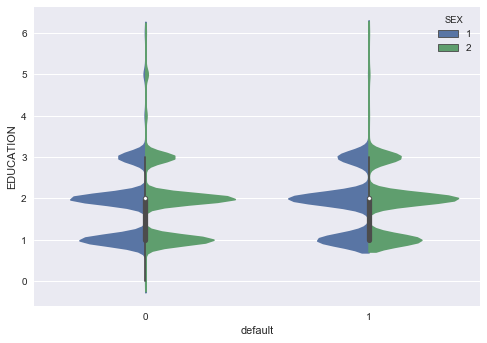

In [30]:
seaborn.violinplot(x="default",y="EDUCATION", hue="SEX", data=data, split=True);

In [31]:
avarage_default = float(len(data[data.default == 1]))/len(data)
print u'Доля заемщиков допустивших дефолт:', avarage_default

Доля заемщиков допустивших дефолт: 0.2212


In [32]:
table = pd.pivot_table(data_new,values=['Count'], index=['EDUCATION'], columns=['default'], aggfunc=np.sum,fill_value=0)

In [33]:
table

Count      
default        0     1
EDUCATION             
0             14     0
1           8549  2036
2          10700  3330
3           3680  1237
4            116     7
5            262    18
6             43     8

In [210]:
from scipy.stats import chi2_contingency

Для категориальных признаков критерий хи-квадрат проверяет гипотезу о равенстве
нулю коэффициента V Крамера против альтернативы, что он нулю не равен

In [34]:
stat_chi2, p_value,dim, predict = chi2_contingency(table)
print  p_value

1.23326262454e-32


Гипотеза о равенстве нулю коэффициента V Крамера уверенно отвергается.

Таблица с абсолютными разностями между наблюдаемым и ожидаемым колличеством вернувших кредит в каждой категории

In [212]:
table - predict

Count          
default           0         1
EDUCATION                    
0            3.0968   -3.0968
1          305.4020 -305.4020
2         -226.5640  226.5640
3         -149.3596  149.3596
4           20.2076  -20.2076
5           43.9360  -43.9360
6            3.2812   -3.2812

Коэффициент V Крамера

In [228]:
VKramer  = (stat_chi2/30000)**0.5
print VKramer

0.0737600971325


In [35]:
array=[]
for i in table.index:
    Count =float(table.iat[i,0]+table.iat[i,1])
    
    # разница между наблюдаемым и ожидаемым значением возврата долга отнесенная к колличеству людей в категории
    # c данным уровнем образования.
    array.append((table.iat[i,0]-Count*(1-avarage_default))/Count)

Table = pd.DataFrame(np.array(array).reshape(1,7))

Table.columns = [u'phd',u'Магистр',u'Бакалавр',u'Выпускник школы',u'Нач. обр.',u'Прочее', u'Нет данных']
Table.index = ['Возврат долга']
print Table 

                  phd   Магистр  Бакалавр  Выпускник школы  Нач. обр.  \
Возврат долга  0.2212  0.028852 -0.016149        -0.030376   0.164289   

                 Прочее  Нет данных  
Возврат долга  0.156914    0.064337  


Кандидаты наук( phd) и люди имеющие начальное образование возвращают кредиты лучше остлальных. 

## 4. Семейное положение (MARRIAGE)
         Связь семейного статуса с индикатором дефолта.

In [36]:
M_table = pd.pivot_table(data_new,values=['Count'], index=['MARRIAGE'], columns=['default'], aggfunc=np.sum,fill_value=0)

In [37]:
M_table

Count      
default       0     1
MARRIAGE             
0            49     5
1         10453  3206
2         12623  3341
3           239    84

In [261]:
print float(a)/(a+b)-float(c)/(c+d)

-0.0254336487641


Коэффициента корреляции Мэтьюса между семейным положением и индикатором дефолта

In [38]:
def MTT(conf_matrix):
    a= float(conf_matrix[0,0])
    b= float(conf_matrix[0,1])
    c= float(conf_matrix[1,0])
    d= float(conf_matrix[1,1])

    return ( (a*d-b*c)/((a+b)*(a+c)*(b+d)*(c+d))**0.5)

In [45]:
conf_matrix = M_table.iloc[1:3,0:2].as_matrix()

In [46]:
MTT(conf_matrix)

-0.030555369920445503

In [47]:
    a= float(conf_matrix[0,0])
    b= float(conf_matrix[0,1])
    c= float(conf_matrix[1,0])
    d= float(conf_matrix[1,1])

Нулевая гипотеза H0 : индикатор дефолта не зависит от семейного положения, против двусторонней альтернативы критерием хи-квадрат уверенно отвергается.

In [48]:
chi2_contingency([[a,b],[c,d]])[1]

1.5633210355976673e-07

Интервальные оценки для долей

In [50]:
import statsmodels.stats.proportion

In [51]:
conf_interval_banner_a = proportion_confint(a,  a+b, method = 'wilson')
conf_interval_banner_b = proportion_confint(c,  c+d,  method = 'wilson')

NameError: name 'proportion_confint' is not defined

In [276]:
print 'Доверительный интервал для доли возвращающих кредит среди married :', conf_interval_banner_a

Доверительный интервал для доли возвращающих кредит среди married : (0.75810140077686039, 0.77231535197857426)


In [277]:
print  'Доверительный интервал для доли возвращающих кредит среди unmarried :',conf_interval_banner_b

Доверительный интервал для доли возвращающих кредит среди unmarried : (0.78433667165500864, 0.79695667497153799)


Интервалы не пересекаются. 

Доверительный интервал для разности долей (независимые выборки)

In [271]:
def proportions_confint_diff_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.) 
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [273]:
married =[1]*a +[0]*b
single =[1]*c +[0]*d

In [278]:
print "confidence interval: [%f, %f]" % proportions_confint_diff_ind(single, married)

confidence interval: [0.015929, 0.034938]


Холостые и незамужние возвращают кредит несколько лучше.

## 5. Возраст (AGE) 
        Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: 
        a) о равенстве медианных значений возрастов людей 
        b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 
        Значимы ли полученные результаты с практической точки зрения?

In [279]:
from sklearn import cross_validation, datasets, linear_model, metrics

G:\Python\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [310]:
Default_age =data[data.default == 1]['AGE']
No_default_age = data[data.default == 0]['AGE']

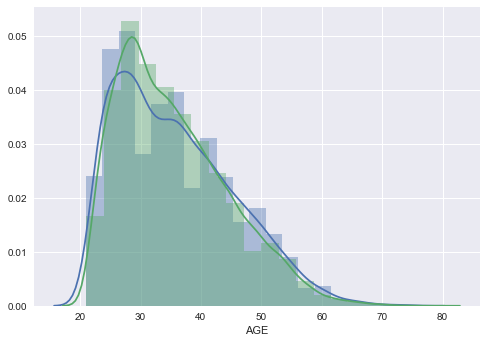

In [399]:
seaborn.distplot(Default_age,bins=20)
seaborn.distplot(No_default_age,bins=20)

### Точечная оценка разности медиан

In [313]:
Default_age.median()- No_default_age.median()

0.0

Точечная оценка говорит о равенстве медианных значений возрастов

### Интервальная оценка разности медиан с помощью bootstrap выборок

In [318]:
Default_median_scores = map(np.median, get_bootstrap_samples(np.array(Default_age), 4000))
No_default_median_scores = map(np.median, get_bootstrap_samples(np.array(No_default_age), 4000))

In [319]:
delta_median_scores = map(lambda x: x[1] - x[0], zip(Default_median_scores, No_default_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [-1.  0.]


### Двухвыборочные критерии для независимых выборок

### Ранговый критерий Манна-Уитни

In [322]:
stats.mannwhitneyu(Default_age, No_default_age)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.18625177174493079)

H0 : среднее значение возрастов в двух группах не отличаются, против двухсторонней альтернативы H1 : среднее значение показа-
теля респираторного обмена отличается в двух группах. Критерий Манни-Уитни даёт достигаемый уровень
значимости p =0.18 не отвергая H0. 